In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# <br>
# 전처리

In [2]:
온라인 = pd.read_csv('/Users/yaelinjo/Desktop/RecoSys/제6회 L.POINT Big Data Competition/제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv', encoding='utf-8')
온라인 = 온라인.sort_values(['clnt_id','sess_id','hit_seq']).reset_index(drop=True)
온라인.shape

/Users/yaelinjo/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3196362, 14)

In [3]:
온라인['unique_id'] = list(map(lambda x,y: str(x)+'_'+str(y), 온라인.clnt_id, 온라인.sess_id))
온라인.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,unique_id
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,1_1
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,1_1
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,1_1
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,1_2
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,1_2


In [5]:
# 온라인 고객: 72,399명, 고객 및 세션: 367,149개
온라인.clnt_id.nunique(), 온라인.unique_id.nunique()

(72399, 367149)

In [9]:
# 각 clnt_id별 session이 바뀌는 지점 index 저장
idx1 = 온라인.unique_id.drop_duplicates().index.tolist()
idx2 = idx1[1:] + [len(온라인)]

In [8]:
# session별 체류시간 = 다음 hit_pss_tm - 이전 hit_pss_tm
stay_tm = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].hit_pss_tm
    if len(temp) == 1:
        stay_tm.append(temp.tolist())
    else:
        temp = temp.diff().tolist()[1:]
        temp.append(temp[-1]) # 마지막은 해당 hit_pss_tm 값 사용
        stay_tm.append(temp)
    #stay_tm = stay_tm + 온라인.iloc[i:j].hit_pss_tm.diff().fillna(0).tolist()

In [9]:
#stay_tm = sum(stay_tm, []) # 시간 매우 오래걸림
온라인['time_length'] = list(itertools.chain.from_iterable(stay_tm))

In [10]:
# 밀리초->초 변환
온라인['hit_pss_tm'] = np.ceil(온라인['hit_pss_tm']/1000)
온라인['time_length'] = np.ceil(온라인['time_length']/1000)

In [11]:
# 주말 및 공휴일 여부
holiday_diff = []
for i in 온라인.sess_dt.map(lambda x: str(x)[-3:]).tolist():
    if i in (['706','707','713','714','717','720','721','727','728',
               '803','804','810','811','815','817','818','824','825',
               '907','908','912','913','914','915','921','922','928','929']):
        holiday_diff.append(1)
    else:
        holiday_diff.append(0)
온라인['holiday_diff'] = holiday_diff

In [12]:
# keyword: session별 sech_kwd의 cumulative sum
온라인['sech_kwd'] = 온라인.sech_kwd.map(lambda x: 0 if str(x) == 'nan' else 1)
keyword = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].sech_kwd
    keyword.append(np.cumsum(temp.tolist()))
온라인['keyword'] = list(itertools.chain.from_iterable(keyword))

In [13]:
온라인['sess_dt'] = 온라인['sess_dt'].map(lambda x: str(x)[:-2]) # day제거하고 month(7,8,9월)만 남김
온라인['dvc_ctg_nm'].fillna('unknown',inplace=True) # device null값을 unknown으로 대체

# dummy variable 생성 - action_type, biz_unit, sess_dt, trfc_src, dvc_ctg_nm
온라인 = pd.concat([온라인, pd.get_dummies(온라인[['biz_unit','sess_dt','trfc_src','dvc_ctg_nm']], drop_first=True)], axis=1)
온라인 = pd.concat([온라인, pd.get_dummies(온라인.action_type, drop_first=True, prefix='action_type')], axis=1)
온라인 = 온라인.drop(['action_type','biz_unit','sess_dt','hit_tm','sech_kwd','tot_pag_view_ct', 'tot_sess_hr_v','trfc_src','dvc_ctg_nm'], axis=1)

In [14]:
온라인 = 온라인[['clnt_id', 'sess_id', 'trans_id', 'hit_seq', 'hit_pss_tm', 'time_length', 'holiday_diff', 'keyword',
                'action_type_1', 'action_type_2', 'action_type_3','action_type_4', 'action_type_5', 'action_type_6', 'action_type_7',
                'biz_unit_A02', 'biz_unit_A03', 'sess_dt_201908', 'sess_dt_201909', 
                'trfc_src_PORTAL_1', 'trfc_src_PORTAL_2', 'trfc_src_PORTAL_3', 'trfc_src_PUSH', 'trfc_src_WEBSITE', 'trfc_src_unknown', 
                'dvc_ctg_nm_mobile_app','dvc_ctg_nm_mobile_web', 'dvc_ctg_nm_unknown', 'unique_id']]
print(온라인.shape)
온라인.head()

(3196362, 29)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_1,action_type_2,...,trfc_src_PORTAL_1,trfc_src_PORTAL_2,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id
0,1,1,NaN,1,12.0,11.0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1_1
1,1,1,NaN,2,23.0,14.0,0,2,0,0,...,0,0,0,0,0,1,1,0,0,1_1
2,1,1,NaN,3,37.0,14.0,0,3,0,0,...,0,0,0,0,0,1,1,0,0,1_1
3,1,2,NaN,1,42.0,15.0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,1_2
4,1,2,NaN,2,57.0,14.0,1,2,0,0,...,0,0,0,0,0,1,1,0,0,1_2


In [15]:
# 저장하고 가자
온라인.to_csv('온라인_전처리_final.csv', index=False)

In [2]:
# 저장한 것 불러와
import pandas as pd

온라인 = pd.read_csv('온라인_전처리_final.csv')

In [3]:
# 각 hit_seq 당 action_type이 구매완료=1, 이외=0
온라인['buy'] = 온라인['action_type_6']
온라인 = 온라인.drop('action_type_6', axis=1)
print(온라인.shape)
온라인.head()

(3196362, 29)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_1,action_type_2,...,trfc_src_PORTAL_2,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,0,0,...,0,0,0,0,1,1,0,0,1_1,0
1,1,1,NaN,2,23.0,14.0,0,2,0,0,...,0,0,0,0,1,1,0,0,1_1,0
2,1,1,NaN,3,37.0,14.0,0,3,0,0,...,0,0,0,0,1,1,0,0,1_1,0
3,1,2,NaN,1,42.0,15.0,1,1,0,0,...,0,0,0,0,1,1,0,0,1_2,0
4,1,2,NaN,2,57.0,14.0,1,2,0,0,...,0,0,0,0,1,1,0,0,1_2,0


# <br>
# 모델링

In [4]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
def make_padding_and_oversample(X, Y, length=70):
    max_len = length #np.percentile(pd.Series(idx),99)
    X_padding = sequence.pad_sequences(X, maxlen=max_len, padding='pre', truncating='post')
    X_padding2 = X_padding.reshape(X.shape[0], max_len* X_padding.shape[2])

    smote = SMOTE(random_state=0)
    X_resampled, Y_resampled = smote.fit_resample(X_padding2, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, X_padding.shape[2])
    return X_padding, X_resampled, Y_resampled

## 각 session의 첫번째 구매완료 이전까지 data만 사용

In [7]:
# 고객별 세션당 구매 횟수: 0~25까지 다양함
# 우선 첫번째 구매를 기준으로 자름
온라인.groupby('unique_id').buy.sum().value_counts()

0     319742
1      40869
2       5104
3       1007
4        262
5         86
6         38
7         10
8          6
10         6
9          4
11         4
12         3
17         3
21         2
15         1
18         1
25         1
Name: buy, dtype: int64

In [10]:
idx3 = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.buy.iloc[i:j]
    try:
        idx3.append(temp[temp == 1].index[0])
    except:
        idx3.append(j)

In [11]:
# (session, sequence, variables) 3d array 변환
# 3d array는 머신 러닝 모델에 적합하지 않음으로, 추후 1d array로 다시 변환할 것
# 1d array에서는 sequence number('hit_seq')가 의미 없으므로, 이름 제외하고 hit_pss_time부터 input으로 사용
온라인_x = []
for i, j in tqdm_notebook(zip(idx1, idx3), total=len(idx1)):
    온라인_x.append(온라인.iloc[i:j, 4:-2].values)
    
#scaler = StandardScaler() 
#scaler = MinMaxScaler(feature_range=(0, 1))
#온라인_x = scaler.fit_transform(np.array(온라인_x))
온라인_x = np.array(온라인_x)

In [12]:
# session 당 구매 여부
온라인_y = []
for i,j in tqdm_notebook(zip(idx1,idx2), total=len(idx1)):
    온라인_y.append([int(온라인.buy.iloc[i:j].sum()>0)])

In [39]:
# 구매완료한 session이 전체의 약 13%
pd.Series(온라인_y).value_counts()*100/온라인.unique_id.nunique()

[0]    87.087804
[1]    12.912196
dtype: float64

In [40]:
idx = list(pd.Series(idx2) - pd.Series(idx1))
np.percentile(pd.Series(idx),99)

75.0

In [41]:
idx = list(pd.Series(idx3) - pd.Series(idx1))
np.percentile(pd.Series(idx),99)

70.0

In [42]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(온라인_x, 온라인_y, length=70)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)

In [44]:
X_train.shape, X_test.shape

((447638, 70, 23), (191846, 70, 23))

In [62]:
X_train_1d = X_train.reshape((447638,-1))
X_test_1d = X_test.reshape((191846,-1))

### Gaussian Naive Bayes

In [64]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [67]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.63
F1 score: 0.45
Precision: 0.87
Recall: 0.30


### KNN Classification

In [68]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [69]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.93
F1 score: 0.93
Precision: 0.89
Recall: 0.99


### Decision Tree Classification

In [70]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [71]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.98
F1 score: 0.98
Precision: 0.98
Recall: 0.98


## 구매완료 이전의 hit_seq를 버림
### 각 sequence length의 0.25-0.75배 random값

In [13]:
import random
remove_ratio = pd.Series([random.random() for i in range(len(온라인_x))]) + 0.5
seq_length = pd.Series(온라인_x).map(lambda x: len(x))
remove_seq_length = np.floor(remove_ratio*seq_length)/2 # 각 session에서 버릴 seq 개수

In [14]:
온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))

In [15]:
seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
max_len = np.percentile(seq_length2, 99)
max_len

38.0

In [16]:
온라인_x2 = [np.int64(i) for i in 온라인_x2]

In [17]:
max_len = int(max_len)

In [18]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y, length=max_len)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)

In [19]:
X_train.shape, X_test.shape

((447638, 38, 23), (191846, 38, 23))

In [20]:
X_train_1d = X_train.reshape((447638,-1))
X_test_1d = X_test.reshape((191846,-1))

### Gaussian Naive Bayes

In [88]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [89]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.61
F1 score: 0.42
Precision: 0.84
Recall: 0.28


### KNN Classification

In [21]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.87
F1 score: 0.88
Precision: 0.80
Recall: 0.97


### Decision Tree Classification

In [23]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.91
F1 score: 0.91
Precision: 0.90
Recall: 0.92


### 각 sequence length의 0.5-0.75배 random값

In [25]:
remove_ratio = pd.Series([random.random() for i in range(len(온라인_x))]) + 2
remove_seq_length = np.floor(remove_ratio*seq_length)/4

In [26]:
온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))

In [27]:
seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
max_len = np.percentile(seq_length2,99)
max_len = int(max_len)
max_len

27

In [28]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y,length = int(max_len))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)

(447638, 27, 23)

In [29]:
X_train.shape, X_test.shape

((447638, 27, 23), (191846, 27, 23))

In [30]:
X_train_1d = X_train.reshape((447638,-1))
X_test_1d = X_test.reshape((191846,-1))

### Gaussian Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

Accuracy: 0.63
F1 score: 0.45
Precision: 0.84
Recall: 0.31


### KNN Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

### Decision Tree Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

### 각 sequence length의 0.5배 값

In [ ]:
remove_seq_length = np.floor(0.5*seq_length)
온라인_x2 = list(map(lambda x,y: x[:-y] if y !=0 else x, 
                     pd.Series(온라인_x), 
                     remove_seq_length.astype(int)))
seq_length2 = pd.Series(온라인_x2).map(lambda x: len(x))
max_len = np.percentile(seq_length2,99)
max_len = int(max_len)
max_len

In [ ]:
X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x2), 온라인_y, length= int(max_len))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)

In [ ]:
X_train_1d = X_train.reshape((447638,-1))
X_test_1d = X_test.reshape((191846,-1))

### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

### KNN Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

### Decision Tree Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_1d, y_train)
y_pred = clf.predict(X_test_1d)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('F1 score: %.2f' % f1_score(y_test, y_pred))
print('Precision: %.2f' % precision_score(y_test, y_pred))
print('Recall: %.2f' % recall_score(y_test, y_pred))

# Conv1D + LSTM

In [226]:
model = Sequential()
#model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc',f1_m,precision_m, recall_m])
#print(model.summary())

In [227]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 12s 27us/step - loss: 0.5528 - acc: 0.7195 - f1_m: 0.6860 - precision_m: 0.7819 - recall_m: 0.6181 - val_loss: 0.5134 - val_acc: 0.7414 - val_f1_m: 0.7363 - val_precision_m: 0.7504 - val_recall_m: 0.7230
Epoch 2/25
447638/447638 [==============================] - 10s 21us/step - loss: 0.4706 - acc: 0.7698 - f1_m: 0.7341 - precision_m: 0.8707 - recall_m: 0.6410 - val_loss: 0.5054 - val_acc: 0.7399 - val_f1_m: 0.6610 - val_precision_m: 0.9472 - val_recall_m: 0.5080
Epoch 3/25
447638/447638 [==============================] - 10s 21us/step - loss: 0.4452 - acc: 0.7825 - f1_m: 0.7454 - precision_m: 0.8976 - recall_m: 0.6424 - val_loss: 0.4188 - val_acc: 0.7970 - val_f1_m: 0.7622 - val_precision_m: 0.9184 - val_recall_m: 0.6518
Epoch 4/25
447638/447638 [==============================] - 9s 21us/step - loss: 0.4322 - acc: 0.7883 - f1_m: 0.7516 - precision_m: 0.9082 - recall_m: 0.645

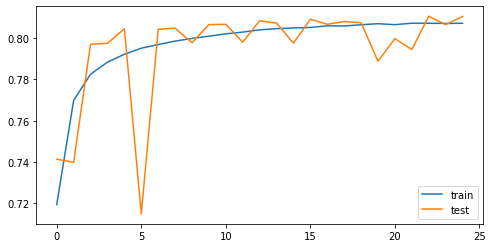

In [228]:
# plot history
plt.figure(figsize=(8,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()                                       
plt.show()

In [230]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

191846/191846 [==============================] - 33s 171us/step


In [231]:
print(accuracy)

0.8104051947593689


In [232]:
model = Sequential()
#model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(128, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(32))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc',f1_m,precision_m, recall_m])
#print(model.summary())

In [233]:
history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=1, shuffle=True)

Train on 447638 samples, validate on 191846 samples
Epoch 1/25
447638/447638 [==============================] - 11s 25us/step - loss: 0.5421 - acc: 0.7258 - f1_m: 0.6797 - precision_m: 0.8175 - recall_m: 0.5940 - val_loss: 0.4704 - val_acc: 0.7680 - val_f1_m: 0.7189 - val_precision_m: 0.9108 - val_recall_m: 0.5941
Epoch 2/25
447638/447638 [==============================] - 10s 23us/step - loss: 0.4678 - acc: 0.7701 - f1_m: 0.7286 - precision_m: 0.8860 - recall_m: 0.6270 - val_loss: 0.4505 - val_acc: 0.7747 - val_f1_m: 0.7248 - val_precision_m: 0.9300 - val_recall_m: 0.5941
Epoch 3/25
447638/447638 [==============================] - 10s 23us/step - loss: 0.4412 - acc: 0.7836 - f1_m: 0.7454 - precision_m: 0.9021 - recall_m: 0.6408 - val_loss: 0.4194 - val_acc: 0.7998 - val_f1_m: 0.7694 - val_precision_m: 0.9057 - val_recall_m: 0.6691
Epoch 4/25
447638/447638 [==============================] - 10s 23us/step - loss: 0.4281 - acc: 0.7898 - f1_m: 0.7534 - precision_m: 0.9097 - recall_m: 0.64

In [234]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

191846/191846 [==============================] - 32s 169us/step


In [237]:
accuracy, f1_score, precision, recall

(0.8059954047203064,
 0.7727072238922119,
 0.9044153094291687,
 0.6840417385101318)

# <br>
# sensitivity analysis

In [222]:
## Sensitivity Analysis
full_X_c = 온라인.iloc[:,3:-2].columns
a_features = int(X_train.shape[2])
importance_df = pd.DataFrame(np.zeros((a_features, 2)), 
                             columns=['varible_name', 'perturbation_effect'])
a_features, len(full_X_c)

(24, 24)

In [238]:
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in tqdm_notebook(range(a_features)):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size= new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = full_X_c[i]
        importance_df.iloc[i,1] = effect
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')

var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Variable 1, perturbation effect: 0.0502
Variable 2, perturbation effect: 0.0055
Variable 3, perturbation effect: 0.0069
Variable 4, perturbation effect: 0.0164
Variable 5, perturbation effect: 0.1752
Variable 6, perturbation effect: 0.1279
Variable 7, perturbation effect: 0.1628
Variable 8, perturbation effect: 0.1527
Variable 9, perturbation effect: 0.0745
Variable 10, perturbation effect: 0.1128
Variable 11, perturbation effect: 0.0138
Variable 12, perturbation effect: 0.0364
Variable 13, perturbation effect: 0.0413
Variable 14, perturbation effect: 0.0295
Variable 15, perturbation effect: 0.0310
Variable 16, perturbation effect: 0.0076
Variable 17, perturbation effect: 0.0057
Variable 18, perturbation effect: 0.0029
Variable 19, perturbation effect: 0.0098
Variable 20, perturbation effect: 0.0077
Variable 21, perturbation effect: 0.0146
Variable 22, perturbation effect: 0.0272
Variable 23, perturbation effect: 0.0357
Variable 24, perturbation effect: 0.0448

             varible_nam

In [239]:
importance_df

,varible_name,perturbation_effect
4,keyword,0.175248
6,action_type_2,0.162847
7,action_type_3,0.152704
5,action_type_1,0.127881
9,action_type_5,0.112824
8,action_type_4,0.074540
0,hit_seq,0.050248
23,dvc_ctg_nm_unknown,0.044779
12,biz_unit_A03,0.041329
11,biz_unit_A02,0.036424


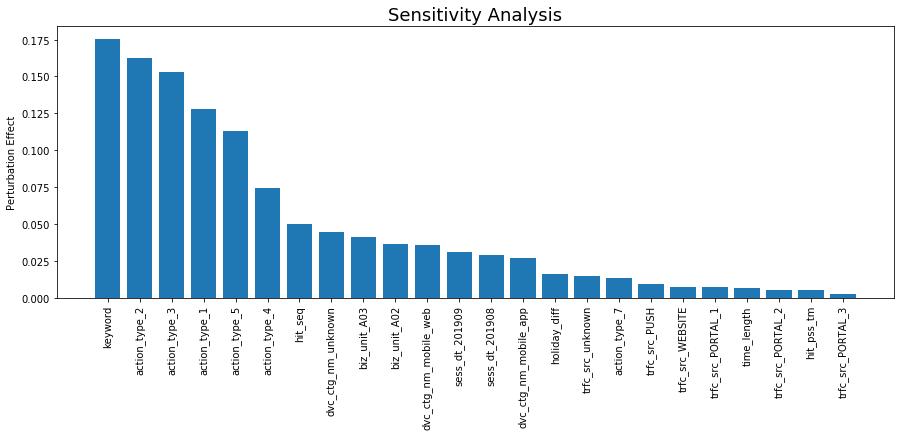

In [248]:
## Plot 예시
#mpl.rc('font', family='New Gulim')
#mpl.rc('axes', unicode_minus=False)
plt.subplots(figsize=(15,5))
plt.bar(importance_df.iloc[:,0], importance_df.iloc[:,1])
plt.title('Sensitivity Analysis', fontsize=18)
#plt.xlabel('IV')
plt.ylabel('Perturbation Effect')
plt.xticks(importance_df.iloc[:,0], rotation=90)
plt.show()

In [246]:
importance_df.perturbation_effect.mean()

0.04972061081192088